In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import scipy
from sklearn import neighbors
import statsmodels.api as sm
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [2]:
grad_df = pd.read_csv('Admission_Predict.csv')

In [3]:
grad_df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
grad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


No missing values. No mixed variable types. 

This dataset contains several important factors for admissions to a Masters program.  These variables will be used to predict the outcome of interest - chance of admittance. I'm going to set the admission rate for this college at 25%.  

In [5]:
#Variable of interest (Chance of Admit) is continuous - change to binary 
grad_df['admit_status'] = grad_df['Chance of Admit '].apply(lambda x: 1 if x>= .75 else 0)
grad_df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,admit_status
0,1,337,118,4,4.5,4.5,9.65,1,0.92,1
1,2,324,107,4,4.0,4.5,8.87,1,0.76,1
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0
3,4,322,110,3,3.5,2.5,8.67,1,0.80,1
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0


In [6]:
#Going to drop Serial No. and Chance of Admit columns - has no useful information
grad_df = grad_df.drop(['Serial No.'], axis=1)

In [7]:
grad_df = grad_df.drop(['Chance of Admit '], axis=1)

In [8]:
#Changing name of some columns for easier use
grad_df = grad_df.rename(columns={'GRE Score':'GRE', 'TOEFL Score':'TOEFL', 'University Rating':'University_Rating'})
grad_df.head()

,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,admit_status
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,0
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0


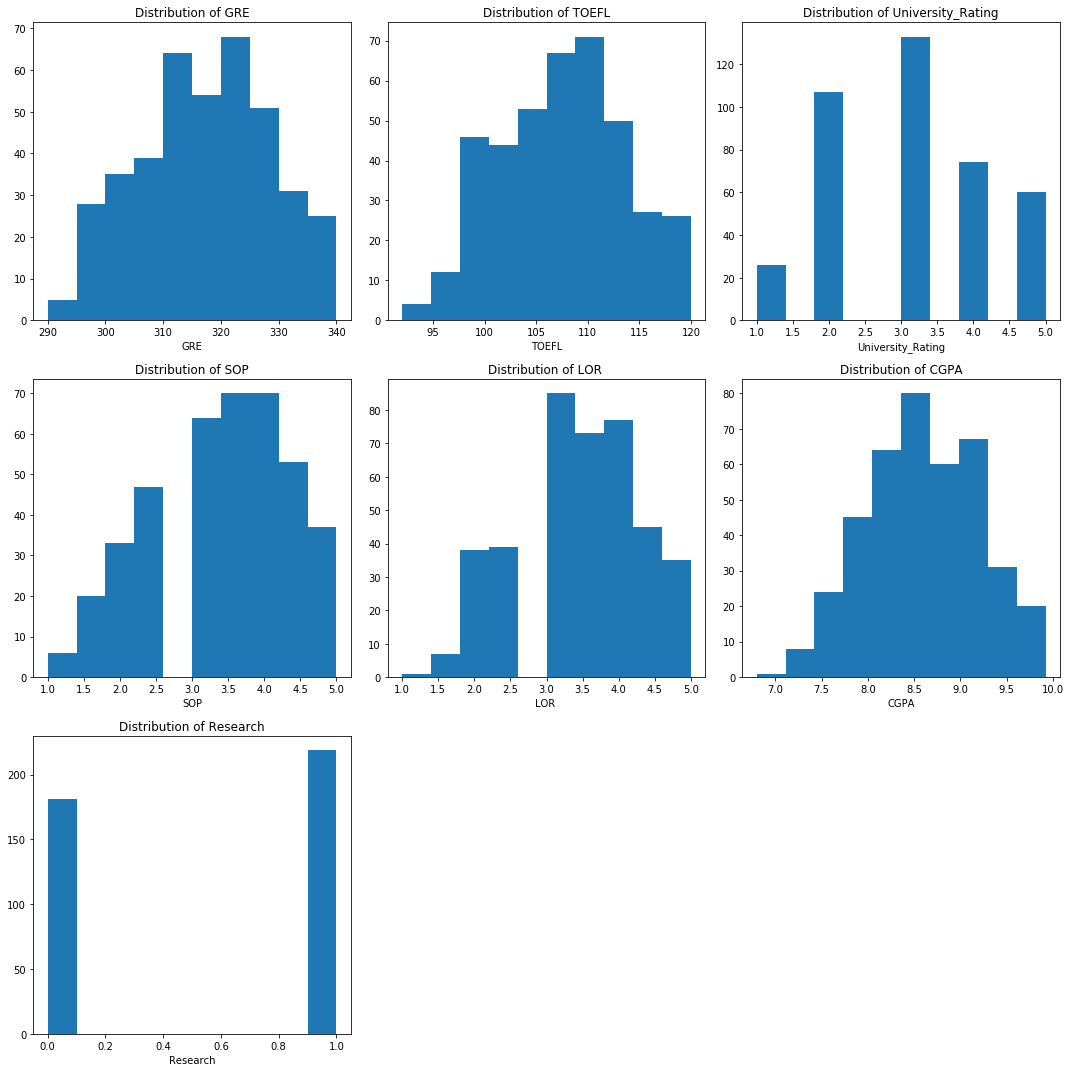

In [9]:
#Exploring distribution of all the features
grad_df2 = grad_df.drop(['admit_status'], axis=1)
all_columns = grad_df2.columns

plt.figure(figsize=(15, 15))
for i in range(len(all_columns)):    
    plt.subplot(3,3,i+1)
    plt.hist(grad_df[all_columns[i]])
    plt.title('Distribution of ' + all_columns[i])
    plt.xlabel(all_columns[i])

plt.tight_layout()
plt.show()

In [10]:
#Exploring correlation of features
grad_df.corr()

,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,admit_status
GRE,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.686138
TOEFL,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.672465
University_Rating,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.638983
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.612152
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.557481
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.737307
Research,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.519441
admit_status,0.686138,0.672465,0.638983,0.612152,0.557481,0.737307,0.519441,1.000000


In [11]:
#Correlation of features with variable of interest - Chance of Admit
grad_df.corr().loc[:,'admit_status'].sort_values(ascending=False)

admit_status         1.000000
CGPA                 0.737307
GRE                  0.686138
TOEFL                0.672465
University_Rating    0.638983
SOP                  0.612152
LOR                  0.557481
Research             0.519441
Name: admit_status, dtype: float64

In [12]:
#setting variable for decision tree model
admit_status = grad_df.admit_status

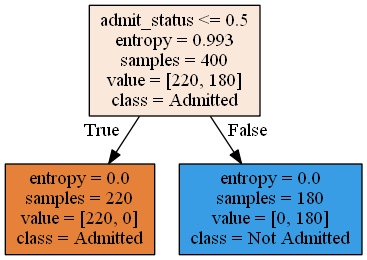

In [13]:
# Decision Tree

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=3,
    random_state = 1337
)
decision_tree.fit(grad_df, admit_status)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=grad_df.columns,
    class_names=['Admitted', 'Not Admitted'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [14]:
# Random Forest

rfc = ensemble.RandomForestClassifier()
X = grad_df.drop('admit_status', 1)
Y = grad_df['admit_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)


c:\users\am\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\am\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\am\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\am\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

array([0.925, 0.775, 0.85 , 0.725, 0.95 , 0.875, 0.875, 0.85 , 0.7  ,
       0.925])